In [1]:
# loading libraries
%load_ext autoreload
%autoreload 2
import sys, os, re
from collections import Counter
import pandas as pd
import numpy as np
from IPython.display import display
sys.path.append(os.path.abspath('../Code'))
from helpers import cumulative_fraction, grams, transpose_note_list
from plot_helpers import *
#from expand_labels import expand_labels, SliceMaker, fifths2name
from ms3.utils import load_tsv, fifths2name, fifths2name, fifths2pc
from ms3.expand_dcml import SM
from ms3 import Parse
#from harmony import regex
#REGEX = re.compile(regex, re.VERBOSE)
from plotly.subplots import make_subplots
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [2]:
# Helper functions
                                     
def plot_cum(S=None, cum=None, x_log=False, markersize=2, left_range=(-0.1, 4.40), right_range=(-0.023,1.099), **kwargs):
    """Pass either a Series or cumulative_fraction(S).reset_index()"""
    if cum is None:
        cum = cumulative_fraction(S).reset_index()
        cum.index = cum.index + 1
    fig = make_subplots(specs=[[{"secondary_y": True,}]])
    ix = cum.index
    fig.add_trace(
        go.Scatter(x=ix, y=cum.x, text=cum['index'], name="Absolute count", mode='markers', marker=dict(size=markersize)),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=ix, y=cum.y, text=cum['index'], name="Cumulative fraction", mode='markers', marker=dict(size=markersize)),
        secondary_y=True,
    )
    fig.update_xaxes(title_text="Rank of chord label", zeroline=False, gridcolor='lightgrey')
    if x_log:
        ranks = np.log(len(ix))/np.log(10)
        fig.update_xaxes(type='log', range=(-0.01*ranks, 1.01*ranks))
    else:
        ranks = len(ix)
        fig.update_xaxes(range=(-0.02*ranks, 1.02*ranks))
    fig.update_yaxes(title_text="Absolute label count", secondary_y=False, type='log', gridcolor='grey', zeroline=True, dtick=1, range=left_range)
    fig.update_yaxes(title_text="Cumulative fraction", secondary_y=True, gridcolor='lightgrey', zeroline=False, dtick=0.1, range=right_range)
    fig.update_layout(**kwargs)
    return fig



# Use ms3 to parse the expanded harmony TSVs

In [3]:
p = Parse('.',  file_re='tsv$', exclude_re='AN.tsv$', index='fname', folder_re='harmonies')
p

93 files.
KEY                                 -> EXTENSIONS
-------------------------------------------------
Couperin-L'art_de_toucher/harmonies -> {'.tsv': 9}
Couperin-gouts_reunis/harmonies     -> {'.tsv': 58}
Couperin-concerts_royaux/harmonies  -> {'.tsv': 26}

In [4]:
{key: [t[0] for t in ix] for key, ix in p.index(per_key=True).items()}

{"Couperin-L'art_de_toucher/harmonies": ['00_allemande',
  '01_premier_prélude_JM',
  '02_second_prélude_JM',
  '03_troisième_prélude_JM',
  '04_quatrième_prélude_JM',
  '05_cinquième_prélude',
  '06_sixième_prélude',
  '07_septième_prélude',
  '08_huitième_prélude'],
 'Couperin-gouts_reunis/harmonies': ['c05n01_prelude',
  'c05n02_allemande',
  'c05n03_sarabande',
  'c05n04_gavote',
  'c05n05_musete',
  'c06n01_grave',
  'c06n02_allemande',
  'c06n03_sarabande',
  'c06n04_air_diable',
  'c06n05_siciliene',
  'c07n01_grave',
  'c07n02_allemande',
  'c07n03_sarabande',
  'c07n04_fuguete',
  'c07n05_gavote',
  'c07n06_siciliene',
  'c08n01_ouverture',
  'c08n02_ritournele',
  'c08n03_air',
  'c08n04_air_tendre',
  'c08n05_air_leger',
  'c08n06_Loure',
  'c08n07_air',
  'c08n08_sarabande',
  'c08n09_air_leger',
  'c08n10_air_lentement',
  'c08n11_air_baccantes',
  'c09n01_charme',
  'c09n02_lenjouement',
  'c09n03_graces',
  'c09n04_Lejene',
  'c09n05_vivacite',
  'c09n06_Sarabande',
  'c

In [5]:
p = Parse('.', key='coup', exclude_re='AN.tsv$', file_re='tsv$', index='fname', folder_re='harmonies')
p.parse_tsv()
p

93 files.
KEY  -> EXTENSIONS
------------------
coup -> {'.tsv': 93}

All 93 tabular files have been parsed, 93 of them as Annotations object(s).
KEY  -> ANNOTATION LAYERS
-------------------------
coup -> staff  voice  label_type
     -> 1      1      3             9217
     ->        2      3               17
     -> 2      1      3                3
     -> 1      1      0               14

In [6]:
df = p.get_labels()
df['key_regions'] = df.groupby(level=0).localkey.apply(lambda col: col != col.shift()).cumsum()
df.head(20)

mc  mn mc_onset mn_onset timesig  staff  voice    label  \
fname                                                                      
00_allemande 0    1   0        0     5/16     4/4      1      1     .d.V   
             1    1   0     3/16      1/2     4/4      1      1       i6   
             2    1   0     7/16      3/4     4/4      1      1        i   
             3    2   1        0        0     4/4      1      1       V6   
             4    2   1      1/4      1/4     4/4      1      1        V   
             5    2   1      1/2      1/2     4/4      1      1     IV65   
             6    2   1      3/4      3/4     4/4      1      1       V7   
             7    3   2        0        0     4/4      1      1       i6   
             8    3   2      1/4      1/4     4/4      1      1      i\\   
             9    3   2      3/8      3/8     4/4      1      1      VI6   
             10   3   2      1/2      1/2     4/4      1      1      iio   
             11   3   2      5/8      5/8     4/4      1      1      VI6   
             12   3   2      3/4      3/4     4/4      1      1   V7/III   
             13   4   3        0        0     4/4      1      1    III\\   
             14   4   3      1/4      1/4     4/4      1      1      V64   
             15   4   3      1/2      1/2     4/4      1      1        i   
             16   4   3      3/4      3/4     4/4      1      1  v.iio64   
             17   4   3      7/8      7/8     4/4      1      1       iv   
             18   5   4        0        0     4/4      1      1        V   
             19   5   4      1/4      1/4     4/4      1      1     V/iv   

                alt_label globalkey localkey pedal   chord numeral form  \
fname                                                                     
00_allemande 0        NaN         d        i   NaN       V       V  NaN   
             1        NaN         d        i   NaN      i6       i  NaN   
             2        NaN         d        i   NaN       i       i  NaN   
             3        NaN         d        i   NaN      V6       V  NaN   
             4        NaN         d        i   NaN       V       V  NaN   
             5        NaN         d        i   NaN    IV65      IV  NaN   
             6        NaN         d        i   NaN      V7       V  NaN   
             7        NaN         d        i   NaN      i6       i  NaN   
             8        NaN         d        i   NaN       i       i  NaN   
             9        NaN         d        i   NaN     VI6      VI  NaN   
             10       NaN         d        i   NaN     iio      ii    o   
             11       NaN         d        i   NaN     VI6      VI  NaN   
             12       NaN         d        i   NaN  V7/III       V  NaN   
             13       NaN         d        i   NaN     III     III  NaN   
             14       NaN         d        i   NaN     V64       V  NaN   
             15       NaN         d        i   NaN       i       i  NaN   
             16       NaN         d        v   NaN   iio64      ii    o   
             17       NaN         d        v   NaN      iv      iv  NaN   
             18       NaN         d        v   NaN       V       V  NaN   
             19       NaN         d        v   NaN    V/iv       V  NaN   

                figbass changes relativeroot phraseend chord_type  \
fname                                                               
00_allemande 0      NaN     NaN          NaN       NaN          M   
             1        6     NaN          NaN       NaN          m   
             2      NaN     NaN          NaN       NaN          m   
             3        6     NaN          NaN       NaN          M   
             4      NaN     NaN          NaN       NaN          M   
             5       65     NaN          NaN       NaN        Mm7   
             6        7     NaN          NaN       NaN        Mm7   
             7        6     NaN          NaN       NaN          m   
   

In [7]:
df.index.is_unique

True

# Unigrams

In [8]:
k = 25
df.chord.value_counts().iloc[:k]

V        1256
I        1057
i         823
V7        471
V65       468
I6        445
i6        403
V43       309
ii%65     238
IV        230
V2        185
ii65      177
V6        159
V(4)      145
ii        134
vi        132
ii%43     127
iv        126
IV6       109
V(64)      93
iv6        83
ii7        78
i64        67
v6         65
ii6        65
Name: chord, dtype: int64

In [9]:
STD_LAYOUT

{'paper_bgcolor': '#FFFFFF',
 'plot_bgcolor': '#FFFFFF',
 'margin': {'l': 40, 'r': 0, 'b': 0, 't': 0, 'pad': 0}}

In [10]:
font_dict = {'font': {'size': 20}}
STD_LAYOUT.update(font_dict)
H_LAYOUT = STD_LAYOUT.copy()
H_LAYOUT.update({'legend': dict({'orientation': 'h', 'itemsizing':'constant', 'x': -0.05}, **font_dict)})

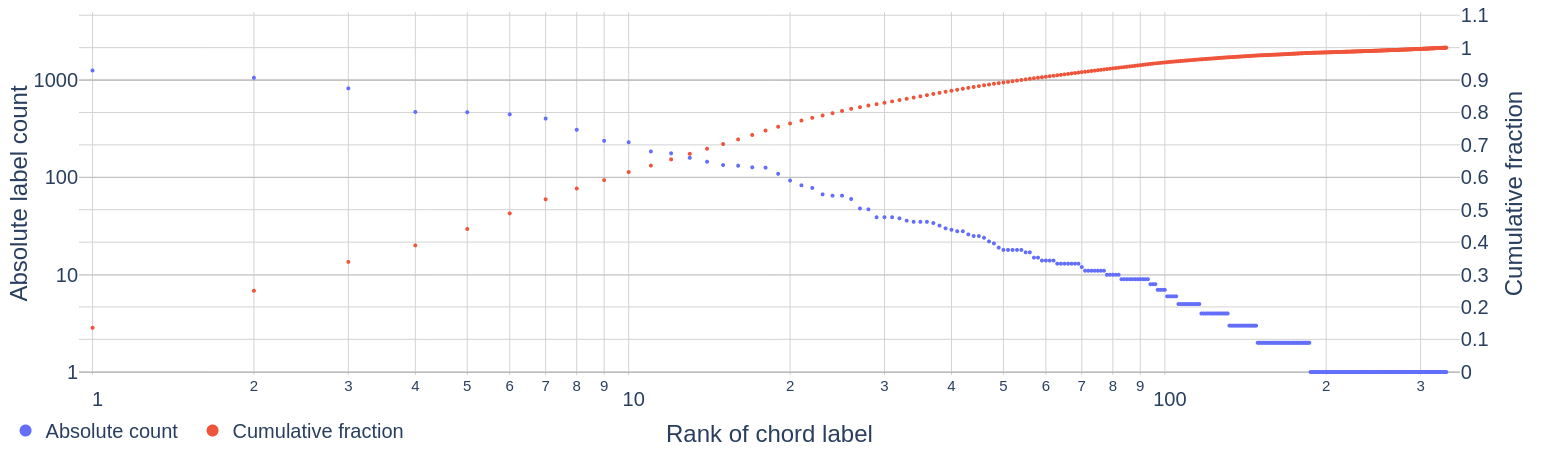

In [11]:
fig = plot_cum(df.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'type_distribution.png', height=400)
#fig.show()

## Unigrams in major segments

In [12]:
minor, major = df[df.localkey_is_minor], df[~df.localkey_is_minor]
print(f"{len(major)} tokens ({len(major.chord.unique())} types) in major and {len(minor)} ({len(minor.chord.unique())} types) in minor.")

4579 tokens (177 types) in major and 4672 (235 types) in minor.


In [13]:
major.chord.value_counts().iloc[:k]

I        987
V        656
I6       441
V7       257
V65      233
IV       176
ii65     159
V43      137
vi       129
V6       119
ii       105
V2        86
V(4)      86
IV6       85
ii7       58
V(64)     53
ii6       48
I64       38
V43/V     35
vi7       33
V65/V     30
ii43      29
vi6       28
iii6      26
IVM7      25
Name: chord, dtype: int64

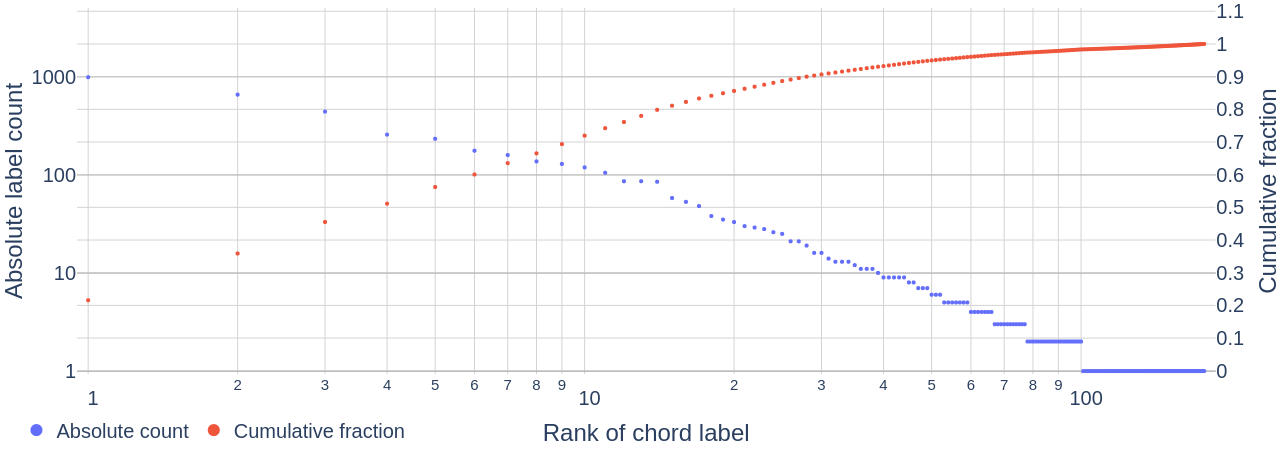

In [14]:
fig = plot_cum(major.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'unigrams_major.png', height=400)

## Unigrams in minor segments

In [15]:
print(f"{len(major)} tokens ({len(major.chord.unique())} types) in major and {len(minor)} ({len(minor.chord.unique())} types) in minor.")

4579 tokens (177 types) in major and 4672 (235 types) in minor.


In [16]:
minor.chord.value_counts().iloc[:k]

i         810
V         600
i6        399
V65       235
ii%65     232
V7        214
V43       172
ii%43     124
iv        123
V2         99
iv6        81
I          70
i64        67
V(4)       59
VI         58
v6         56
IV         54
VIM7       46
V65/iv     45
V6         40
V(64)      40
iv7        37
III        35
iio        35
ii%7       34
Name: chord, dtype: int64

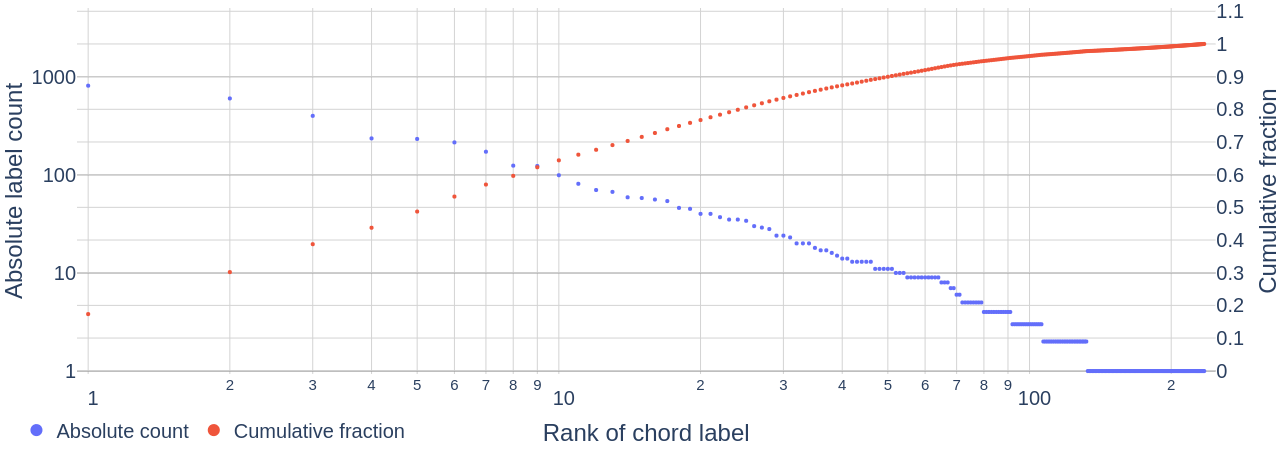

In [17]:
fig = plot_cum(minor.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'unigrams_minor.png', height=400)

# Bigrams

In [18]:
chord_successions = [s.to_list() for _, s in df.groupby('key_regions').chord]

In [19]:
gs = grams(chord_successions)
c = Counter(gs)

In [20]:
dict(sorted(c.items(), key=lambda a: a[1], reverse=True)[:k])

{('V', 'I'): 268,
 ('V7', 'I'): 217,
 ('V', 'i'): 208,
 ('I', 'V'): 179,
 ('i', 'V'): 154,
 ('V', 'V7'): 153,
 ('V65', 'I'): 152,
 ('V7', 'i'): 135,
 ('ii%65', 'V'): 126,
 ('V', 'I6'): 125,
 ('V65', 'i'): 118,
 ('V(4)', 'V'): 107,
 ('V65', 'V7'): 107,
 ('I6', 'I'): 89,
 ('ii65', 'V'): 88,
 ('V43', 'i'): 88,
 ('V43', 'I'): 85,
 ('V', 'i6'): 82,
 ('V2', 'i6'): 82,
 ('i6', 'V43'): 79,
 ('I', 'I6'): 78,
 ('V2', 'I6'): 71,
 ('V', 'V2'): 69,
 ('i6', 'ii%65'): 67,
 ('I6', 'V43'): 65}

## Absolute Counts (read from index to column)

In [21]:
transition_matrix(chord_successions, k=k, dist_only=True)

,total,V,I6,V6,IV,V65,vi,ii65,V(4),V7,V43,IVM7,V(64),IV64,ii2,vi6,IV6,V43/V,viio6,V2,V7/IV,V65/IV,i,ii6,@none
I,758,179,78,50,49,48,42,37,32,28,22,14,13,13,10,10,10,8,8,8,7,6,6,6,5


,total,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,V(4),IV,iv7,iv,V2,i2,iv6,VI6,v,V/iv,III6,VIM7,V65/iv,iv64,iv7(9)
i,639,154,56,55,38,27,25,20,17,15,14,14,14,10,9,9,8,7,7,7,7,7,7,6,6


,total,I,i,V7,I6,i6,V2,V65,V6,iii6,IV6,ii,V43,V6/iv,ii%43,iv6,i64,V65/iv,I64,vi,III+6,v6,ii43,v,ii%65
V,1193,268,208,153,125,82,69,50,22,15,14,13,12,9,9,8,8,7,7,7,6,5,5,5,4


,total,I,i,vi,V(64),V65,I64,VI,i6,i64,V/iv,V,I(7),IV6,i(4),IIIM7(#5),III+6,vi%7,i(9),I6,I(4),I64(2),I6(2),IVM7(9),i6(11#72)
V7,463,217,135,17,13,9,8,8,7,4,4,3,3,2,2,2,2,2,2,2,2,2,1,1,1


,total,I,V43,ii65,IV,V,vi,V(4),ii7,V(64),V6,V65,viio6,IM7,V7/IV,IV(9),IV6,IVM7,IVM7(9),IVM2,I64,V65/IV,V64,vi7,iv7
I6,438,89,65,64,40,31,17,14,14,9,9,9,8,7,6,5,4,4,3,3,3,3,3,2,2


,total,V43,ii%65,i,V65,V,ii%7,#viio65,iv,VI,iv7,IV7(9),i7,V(4),V(64),IV,VIM7,ii65,V6,ii%43,IV2,#viio6,IV(9),V64,vi%7
i6,397,79,67,59,39,20,9,8,8,7,7,6,6,6,5,4,4,4,4,4,3,3,2,2,2


,total,i,I,i6,V65,I6,i64,V,V7,V2,V6,i6(11#72),I(9),i(4),V(64),I64,viio,V65/iv,ii7/iv,iii,I6(42),V/iv,vi6,ii7/IV,i6(119#7)
V43,309,88,85,44,28,26,5,5,5,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,total,i6,I6,V43,i,III+7,V65/iv,I,ii6,V65,V65(2),vi64,iv7(9),V6,iii6,V65/IV,iii,V65/ii,V,ii%65,IV6(9),V(11),ii6(11b62),ii6(9),V6/V
V2,183,82,71,7,5,2,2,2,2,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0


,total,V,V(4),i6,V(64),i64,i,V2,ii%7,ii%43,V7,V64,III+7,ii7,V65,V2/V,V64(9)/iv,V(#64),i6(11#72),ii6,v,V(64)/I,i6(112),V65/V,viio64
ii%65,238,126,22,16,11,11,10,7,6,5,4,3,2,2,2,1,1,1,1,1,1,1,1,1,1


,total,V,V(4),ii43,V(64),ii7,V2,I,V7,ii,I6,IV6,I64,V65/V,V64,viio/V,i,iii6,ii(97),vi7(9),ii6(9),V(11),IV6(9),ii%65,VM7/IV
ii65,176,88,20,12,10,8,7,7,6,3,3,2,2,2,2,1,1,1,1,0,0,0,0,0,0


,total,I,i,V7,V,i6,I(4),i(4),V43,I(9),i(9),i(94),V43/V,V2,I64,I6,V/iv,I(94),i64,ii43,V6,VIM7,ii%43,vi,iM7(9)
V65,465,152,118,107,17,10,9,7,6,6,5,4,3,3,2,2,2,2,1,1,1,1,1,1,1


,total,V,I,V43/V,i,vi,vi7,v6,I6,V65,V7,ii(4),V65/ii,i6,IV6,V64,i64,IV/IV,I64,i6(11#72),ii43,iii6,III+6,IV,vi6
V6,152,28,21,13,10,9,8,8,8,7,5,4,3,3,2,2,2,1,1,1,1,1,1,1,1


,total,ii,I6,V43,ii7,I,ii6,V,V65,V2,V/V,V65/V,IV6,IV2,V(4),ii65,vi,IVM2,IV7,iio,I64,ii43,V7/VII,V(64),viio
IV,216,43,27,24,14,13,12,11,9,7,6,6,6,3,3,3,2,2,2,2,2,1,1,1,1


,total,V,V7,V65,V6,vi,IV6,ii7,IV,iii(9),ii6,V6/V,ii2,V/V,vi%7/V,I6(112),i6(11#72),V7/IV,iii7,viio,V65(6)/ii,viio7,i6,V/vi,#viio
ii,128,44,15,14,7,6,5,5,4,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1


,total,ii65,I6,IV,IV6,V65,I,V,ii%65,vi6,I64,V65/V,ii,IVM7,IVM7(9),ii65(2),V(4)/vi,vi2,iii6,V43,iii,ii%7,V2,V65/ii,IV64(9)
vi,121,30,21,19,9,9,3,3,3,3,3,3,2,2,2,2,1,1,1,1,1,1,1,0,0


,total,V,V7,V7(4),v,V6,ii%43,V65/V,I6,iii6,V(64),V65,V6/V,ii6(9),V(11),IV6(9),ii%65,v(4),IVM7,V65/ii,ii%65(11),IM65,iii%43,IV6/iv,IV64(9)
V(4),145,107,21,5,4,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


,total,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),VII6,V(4),I64,IV6(2),iv7,V65,ii7,ii7/IV,V43/V,iv64,V/IV,V64(13),ii6(11b62),iv43,IM65,i6(11#72)
ii%43,127,44,42,12,9,5,3,3,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0


,total,iv6,iv6(2),VIM7,V2/iv,ii%43,V2/IV,IV6,V43/V,i,IIIM43,#vi7,#vi%7,V6,ii%43(4),IIIM65,#viio6/v,iii7,ii,v,v7,V7/iv,V,IV6(9),III+6
v6,63,8,8,7,5,4,4,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,total,ii%7,i64,V,ii%65,iio,i,i6,iv6,V7/iv,III+6,ii%43,V/III,ii,V65/III,V43,V6/III,iio6,VII6,VII,IV,V(9),V7/III,iv7(9),#viio
iv,113,9,9,8,7,6,6,5,5,5,4,4,4,3,3,3,2,2,2,2,2,2,1,1,1


,total,ii%65,iv,ii65,i6,VIM2,i64,ii%7,V2/III,VI2,VI6,viio43,ii,iv6,ii7,IV7(9),iv7(9),ivM7,V43/V,V/IV,ii6(11b62),iv43,ii7/IV,IM65,vi7(9)
VI,48,23,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0


,total,vi,vi7,ii6,iii,IV6(94),IV6(2),V7,iiiM7,viio6(2)/V,V,V6/V,ii6(9),V(11),IV6(9),vio64,ii%65,vi2,vi7(9),ii%65(11),iii%43,IV6/iv,IV64(9),V65/ii,IVM7
iii6,25,10,4,3,3,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,total,V65,IV,V7,I,V,V6,I6,ii,IV7,V(64),ii7,I(4),iv6,iii6,ii65,ii6,V43,viio,V7/IV,vii%7,viio7,V65(9),#viio,III+6
IV6,109,53,7,5,5,4,4,4,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1


,total,V,V7,I6,V65,V7(4),V43,V(64),i6(11#72),v7,i6(11),ii%65,V65/IV,iio6,I,viio6,V65/V,vii65,ii6(9),iv43,ii7/IV,IM65,vi7(9),V6/V,V(11)
ii7,78,29,17,6,5,4,4,3,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0


,total,ii65,ii6,V,V65/V,ii%43,V(4),viio64,V(11),V/IV,ii7(9),iii6,V(64),I6,IV6/iv,iii%43,ii%65(11),VII(4),IV64(9),v(4),III+(9),ii%65,IV6(9),V65/ii,IVM7
IVM7,28,7,6,3,3,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0


,total,ii%65,V(64),V,V2,#viio43,VII7,V65,VII,ii,V(4),ii65,V7/III,V/III,VII(9),III+(9),iio,II%65,V43,V/IV,ii6(11b62),iv43,ii7/IV,IM65,vi7(9)
iv7,38,8,6,6,2,2,2,2,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0


## Normalized Counts

In [22]:
transition_matrix(chord_successions, k=k, dist_only=True, normalize=True, decimals=2)

,total,V,I6,V6,IV,V65,vi,ii65,V(4),V7,V43,IVM7,V(64),IV64,ii2,vi6,IV6,V43/V,viio6,V2,V7/IV,V65/IV,i,ii6,@none
I,758,0.24,0.1,0.07,0.06,0.06,0.06,0.05,0.04,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,V(4),IV,iv7,iv,V2,i2,iv6,VI6,v,V/iv,III6,VIM7,V65/iv,iv64,iv7(9)
i,639,0.24,0.09,0.09,0.06,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,I,i,V7,I6,i6,V2,V65,V6,iii6,IV6,ii,V43,V6/iv,ii%43,iv6,i64,V65/iv,I64,vi,III+6,v6,ii43,v,ii%65
V,1193,0.22,0.17,0.13,0.1,0.07,0.06,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0


,total,I,i,vi,V(64),V65,I64,VI,i6,i64,V/iv,V,I(7),IV6,i(4),IIIM7(#5),III+6,vi%7,i(9),I6,I(4),I64(2),I6(2),IVM7(9),i6(11#72)
V7,463,0.47,0.29,0.04,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,V43,ii65,IV,V,vi,V(4),ii7,V(64),V6,V65,viio6,IM7,V7/IV,IV(9),IV6,IVM7,IVM7(9),IVM2,I64,V65/IV,V64,vi7,iv7
I6,438,0.2,0.15,0.15,0.09,0.07,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0


,total,V43,ii%65,i,V65,V,ii%7,#viio65,iv,VI,iv7,IV7(9),i7,V(4),V(64),IV,VIM7,ii65,V6,ii%43,IV2,#viio6,IV(9),V64,vi%7
i6,397,0.2,0.17,0.15,0.1,0.05,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,i,I,i6,V65,I6,i64,V,V7,V2,V6,i6(11#72),I(9),i(4),V(64),I64,viio,V65/iv,ii7/iv,iii,I6(42),V/iv,vi6,ii7/IV,i6(119#7)
V43,309,0.28,0.28,0.14,0.09,0.08,0.02,0.02,0.02,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i6,I6,V43,i,III+7,V65/iv,I,ii6,V65,V65(2),vi64,iv7(9),V6,iii6,V65/IV,iii,V65/ii,V,ii%65,IV6(9),V(11),ii6(11b62),ii6(9),V6/V
V2,183,0.45,0.39,0.04,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),i6,V(64),i64,i,V2,ii%7,ii%43,V7,V64,III+7,ii7,V65,V2/V,V64(9)/iv,V(#64),i6(11#72),ii6,v,V(64)/I,i6(112),V65/V,viio64
ii%65,238,0.53,0.09,0.07,0.05,0.05,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),ii43,V(64),ii7,V2,I,V7,ii,I6,IV6,I64,V65/V,V64,viio/V,i,iii6,ii(97),vi7(9),ii6(9),V(11),IV6(9),ii%65,VM7/IV
ii65,176,0.5,0.11,0.07,0.06,0.05,0.04,0.04,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,i,V7,V,i6,I(4),i(4),V43,I(9),i(9),i(94),V43/V,V2,I64,I6,V/iv,I(94),i64,ii43,V6,VIM7,ii%43,vi,iM7(9)
V65,465,0.33,0.25,0.23,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,I,V43/V,i,vi,vi7,v6,I6,V65,V7,ii(4),V65/ii,i6,IV6,V64,i64,IV/IV,I64,i6(11#72),ii43,iii6,III+6,IV,vi6
V6,152,0.18,0.14,0.09,0.07,0.06,0.05,0.05,0.05,0.05,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,ii,I6,V43,ii7,I,ii6,V,V65,V2,V/V,V65/V,IV6,IV2,V(4),ii65,vi,IVM2,IV7,iio,I64,ii43,V7/VII,V(64),viio
IV,216,0.2,0.12,0.11,0.06,0.06,0.06,0.05,0.04,0.03,0.03,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0


,total,V,V7,V65,V6,vi,IV6,ii7,IV,iii(9),ii6,V6/V,ii2,V/V,vi%7/V,I6(112),i6(11#72),V7/IV,iii7,viio,V65(6)/ii,viio7,i6,V/vi,#viio
ii,128,0.34,0.12,0.11,0.05,0.05,0.04,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,ii65,I6,IV,IV6,V65,I,V,ii%65,vi6,I64,V65/V,ii,IVM7,IVM7(9),ii65(2),V(4)/vi,vi2,iii6,V43,iii,ii%7,V2,V65/ii,IV64(9)
vi,121,0.25,0.17,0.16,0.07,0.07,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0


,total,V,V7,V7(4),v,V6,ii%43,V65/V,I6,iii6,V(64),V65,V6/V,ii6(9),V(11),IV6(9),ii%65,v(4),IVM7,V65/ii,ii%65(11),IM65,iii%43,IV6/iv,IV64(9)
V(4),145,0.74,0.14,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),VII6,V(4),I64,IV6(2),iv7,V65,ii7,ii7/IV,V43/V,iv64,V/IV,V64(13),ii6(11b62),iv43,IM65,i6(11#72)
ii%43,127,0.35,0.33,0.09,0.07,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,iv6,iv6(2),VIM7,V2/iv,ii%43,V2/IV,IV6,V43/V,i,IIIM43,#vi7,#vi%7,V6,ii%43(4),IIIM65,#viio6/v,iii7,ii,v,v7,V7/iv,V,IV6(9),III+6
v6,63,0.13,0.13,0.11,0.08,0.06,0.06,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


,total,ii%7,i64,V,ii%65,iio,i,i6,iv6,V7/iv,III+6,ii%43,V/III,ii,V65/III,V43,V6/III,iio6,VII6,VII,IV,V(9),V7/III,iv7(9),#viio
iv,113,0.08,0.08,0.07,0.06,0.05,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


,total,ii%65,iv,ii65,i6,VIM2,i64,ii%7,V2/III,VI2,VI6,viio43,ii,iv6,ii7,IV7(9),iv7(9),ivM7,V43/V,V/IV,ii6(11b62),iv43,ii7/IV,IM65,vi7(9)
VI,48,0.48,0.1,0.08,0.06,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,vi,vi7,ii6,iii,IV6(94),IV6(2),V7,iiiM7,viio6(2)/V,V,V6/V,ii6(9),V(11),IV6(9),vio64,ii%65,vi2,vi7(9),ii%65(11),iii%43,IV6/iv,IV64(9),V65/ii,IVM7
iii6,25,0.4,0.16,0.12,0.12,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65,IV,V7,I,V,V6,I6,ii,IV7,V(64),ii7,I(4),iv6,iii6,ii65,ii6,V43,viio,V7/IV,vii%7,viio7,V65(9),#viio,III+6
IV6,109,0.49,0.06,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,V,V7,I6,V65,V7(4),V43,V(64),i6(11#72),v7,i6(11),ii%65,V65/IV,iio6,I,viio6,V65/V,vii65,ii6(9),iv43,ii7/IV,IM65,vi7(9),V6/V,V(11)
ii7,78,0.37,0.22,0.08,0.06,0.05,0.05,0.04,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii65,ii6,V,V65/V,ii%43,V(4),viio64,V(11),V/IV,ii7(9),iii6,V(64),I6,IV6/iv,iii%43,ii%65(11),VII(4),IV64(9),v(4),III+(9),ii%65,IV6(9),V65/ii,IVM7
IVM7,28,0.25,0.21,0.11,0.11,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V(64),V,V2,#viio43,VII7,V65,VII,ii,V(4),ii65,V7/III,V/III,VII(9),III+(9),iio,II%65,V43,V/IV,ii6(11b62),iv43,ii7/IV,IM65,vi7(9)
iv7,38,0.21,0.16,0.16,0.05,0.05,0.05,0.05,0.05,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Entropy

In [23]:
transition_matrix(chord_successions, k=k, IC=True, dist_only=True, smooth=1, decimals=2)

,V,I6,V6,IV,V65,vi,ii65,V(4),V7,V43,IVM7,entropy,V(64),IV64,ii2,IV6,vi6,V43/V,V2,viio6,V7/IV,ii6,i,V65/IV,@none
I,2.59,3.78,4.41,4.44,4.47,4.66,4.84,5.04,5.23,5.56,6.18,6.26,6.28,6.28,6.63,6.63,6.63,6.92,6.92,6.92,7.09,7.28,7.28,7.28,7.5


,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,V(4),IV,iv7,iv,entropy,i2,V2,iv6,VI6,V65/iv,VIM7,III6,V/iv,v,iv64,iv7(9)
i,2.64,4.09,4.11,4.63,5.11,5.22,5.53,5.75,5.92,6.01,6.01,6.01,6.46,6.59,6.6,6.6,6.75,6.92,6.92,6.92,6.92,6.92,6.92,7.11,7.11


,I,i,V7,I6,i6,V2,V65,entropy,V6,iii6,IV6,ii,V43,ii%43,V6/iv,iv6,i64,vi,V65/iv,I64,III+6,ii43,v,v6,IV
V,2.5,2.86,3.3,3.59,4.2,4.44,4.9,5.43,6.05,6.57,6.66,6.76,6.87,7.25,7.25,7.4,7.4,7.57,7.57,7.57,7.76,7.99,7.99,7.99,8.25


,I,i,vi,entropy,V(64),V65,I64,VI,i6,V/iv,i64,I(7),V,IV6,i(4),IIIM7(#5),III+6,I(4),vi%7,I64(2),i(9),I6,#viio,IIIM7(9),V/IV
V7,1.86,2.54,5.46,5.82,5.82,6.31,6.46,6.46,6.63,7.31,7.31,7.63,7.63,8.04,8.04,8.04,8.04,8.04,8.04,8.04,8.04,8.04,8.63,8.63,8.63


,I,V43,ii65,IV,V,vi,ii7,V(4),V65,V(64),V6,viio6,IM7,entropy,V7/IV,IV(9),IVM7,IV6,IVM2,I64,V64,V65/IV,IVM7(9),ii43,iv7
I6,3.09,3.54,3.56,4.23,4.58,5.41,5.68,5.68,6.26,6.26,6.26,6.41,6.58,6.64,6.78,7.0,7.26,7.26,7.58,7.58,7.58,7.58,7.58,8.0,8.0


,V43,ii%65,i,V65,V,ii%7,iv,#viio65,VI,iv7,i7,IV7(9),V(4),entropy,V(64),ii%43,ii65,VIM7,IV,V6,IV2,#viio6,IV(9),iv7(9),vi%7
i6,3.18,3.42,3.6,4.18,5.11,6.18,6.33,6.33,6.5,6.5,6.7,6.7,6.7,6.8,6.92,7.18,7.18,7.18,7.18,7.18,7.5,7.5,7.92,7.92,7.92


,i,I,i6,V65,I6,entropy,V,V7,i64,V2,V6,vi6,viio,v7,ii7/IV,i6(119#7),ii7/iv,i(4),V/iv,IV65,i6(9),I(9),iii,i6(11#72),V65/iv
V43,2.84,2.89,3.83,4.46,4.56,6.59,6.73,6.73,6.73,7.73,7.73,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32,8.32


,i6,I6,V43,i,entropy,V65/iv,I,ii6,III+7,V65,V65(2),V65/ii,iii,vi64,iv7(9),V65/IV,iii6,V6,IM65,#viio/iv,vi7(9),V6/V,ii6(9),V(11),IV6(9)
V2,2.62,2.83,6.0,6.42,6.94,7.42,7.42,7.42,7.42,7.42,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0


,V,V(4),i6,V(64),i64,i,V2,ii%7,ii%43,V7,entropy,V64,ii7,V65,III+7,V(#64),V65/V,V43,i6(11#72),V2/V,V64(9)/iv,viio64,v,ii6,V(64)/I
ii%65,2.16,4.62,5.06,5.56,5.56,5.69,6.15,6.34,6.56,6.83,6.85,7.15,7.56,7.56,7.56,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15


,V,V(4),ii43,V(64),ii7,V2,I,V7,ii,I6,entropy,I64,V64,V65/V,IV6,i,iii6,viio/V,ii(97),ii6(9),V(11),IV6(9),ii%65,VM7/IV,ii%65(11)
ii65,2.5,4.59,5.28,5.52,5.81,5.98,5.98,6.17,6.98,6.98,7.21,7.4,7.4,7.4,7.4,7.98,7.98,7.98,7.98,8.98,8.98,8.98,8.98,8.98,8.98


,I,i,V7,V,entropy,i6,I(4),i(4),V43,I(9),i(9),i(94),V43/V,V2,V/iv,I64,I6,I(94),V6,VIM7,i64,ii43,iM7(9),I6(112),ii%43
V65,2.38,2.74,2.88,5.46,5.91,6.17,6.31,6.63,6.83,6.83,7.05,7.31,7.63,7.63,8.05,8.05,8.05,8.05,8.63,8.63,8.63,8.63,8.63,8.63,8.63


,V,I,V43/V,i,vi,vi7,I6,v6,V65,V7,ii(4),V65/ii,i6,V64,i64,IV6,entropy,#vio6,ii43,I64,IV/IV,iii%43,iii,V/V,IV
V6,4.05,4.45,5.1,5.45,5.59,5.74,5.74,5.74,5.91,6.32,6.59,6.91,6.91,7.32,7.32,7.32,7.73,7.91,7.91,7.91,7.91,7.91,7.91,7.91,7.91


,ii,I6,V43,ii7,I,ii6,V,V65,V2,V/V,V65/V,IV6,IV2,ii65,V(4),entropy,IV7,vi,iio,IVM2,I64,V6,ii43,iio6,iv7
IV,3.63,4.28,4.45,5.18,5.28,5.39,5.51,5.77,6.09,6.28,6.28,6.28,7.09,7.09,7.09,7.45,7.51,7.51,7.51,7.51,7.51,8.09,8.09,8.09,8.09


,V,V7,V65,V6,vi,ii7,IV6,IV,iii(9),ii6,V6/V,entropy,#viio,ii2,viio7,V/vi,ii(9),V65(6)/ii,viio,iii7,i6(11#72),vi%7/V,V/V,vi6,i6
ii,3.34,4.84,4.93,5.84,6.03,6.25,6.25,6.51,6.84,7.25,7.25,7.71,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84,7.84


,ii65,I6,IV,V65,IV6,V65/V,I,V,ii%65,vi6,I64,ii,IVM7,IVM7(9),ii65(2),entropy,vi2,ii%7,V43,V2,iii6,iii,V(4)/vi,v6,IV6(9)
vi,3.86,4.35,4.49,5.49,5.49,6.81,6.81,6.81,6.81,6.81,6.81,7.23,7.23,7.23,7.23,7.73,7.81,7.81,7.81,7.81,7.81,7.81,7.81,8.81,8.81


,V,V7,V7(4),v,entropy,V6,ii%43,iii6,I6,V(64),V65,V65/V,V65/III,IVM7,#viio43,V65/ii,IV64(9),IV6/iv,iii%43,ii%65(11),v(4),vi2,ii%65,IV6(9),V(11)
V(4),2.13,4.43,6.3,6.57,7.05,7.3,7.89,7.89,7.89,7.89,7.89,7.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89,8.89


,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),entropy,ii7,V(4),VII6,I64,IV6(2),iv7,V65,III,i6(2),IV6(9),V(11),ii6(9),V6/V,vi7(9),IM65,ii7/IV
ii%43,3.34,3.41,5.13,5.51,6.25,6.83,6.83,7.25,7.49,7.83,7.83,7.83,7.83,7.83,7.83,7.83,8.83,8.83,8.83,8.83,8.83,8.83,8.83,8.83,8.83


,iv6(2),iv6,VIM7,V2/iv,V2/IV,ii%43,IIIM43,IV6,V43/V,i,III6,#vi%7,V6,ii%43(4),V7/iv,IIIM65,#vi7,#viio6/v,III+6,V/iv,v,v7,ii,vi7,iii%43
v6,5.44,5.44,5.61,6.03,6.29,6.29,7.03,7.03,7.03,7.03,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61,7.61


,ii%7,i64,V,ii%65,i,iio,iv6,i6,V7/iv,ii%43,III+6,V/III,V43,V65/III,ii,VII6,V6/III,iio6,IV,VII,V(9),V43/iv,V/VII,V2,#viio
iv,5.47,5.47,5.62,5.79,5.98,5.98,6.2,6.2,6.2,6.47,6.47,6.47,6.79,6.79,6.79,7.2,7.2,7.2,7.2,7.2,7.2,7.79,7.79,7.79,7.79


,ii%65,iv,ii65,i6,VIM2,ii7,V2/III,ii%7,VI2,IV7(9),iv7(9),VI6,viio43,ii,iv6,i64,entropy,III,bII,V64(13),IV6(9),V(11),ii6(9),V6/V,IV2
VI,3.97,5.97,6.24,6.56,6.97,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,7.56,8.1,8.56,8.56,8.56,8.56,8.56,8.56,8.56,8.56


,vi,vi7,iii,ii6,IV6(94),viio6(2)/V,IV6(2),iiiM7,V7,entropy,V,vi7(9),ii%65(11),iii%43,IV6(9),V(11),IV6/iv,IV64(9),ii6(9),V65/ii,V6/V,IVM7,v(4),ii%65,ii7/IV
iii6,5.01,6.15,6.47,6.47,7.47,7.47,7.47,7.47,7.47,8.25,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47,8.47


,V65,IV,V7,I,V,V6,I6,ii,IV7,iv6,iii6,I(4),V(64),ii7,entropy,vii%7,V65(9),viio,viio7,ii65,ii6,V7/IV,#viio,III+6,V43
IV6,3.02,5.77,6.19,6.19,6.45,6.45,6.45,6.77,6.77,7.19,7.19,7.19,7.19,7.19,7.72,7.77,7.77,7.77,7.77,7.77,7.77,7.77,7.77,7.77,7.77


,V,V7,I6,V65,V43,V7(4),V(64),i6(11#72),i6(11),viio6,ii%65,I,iio6,v7,V65/IV,V65/V,entropy,IV6/iv,V(11),ii%65(11),v(4),IV64(9),V65/ii,viio43,IV6(9)
ii7,3.76,4.5,5.86,6.08,6.35,6.35,6.67,7.08,7.67,7.67,7.67,7.67,7.67,7.67,7.67,7.67,7.91,8.67,8.67,8.67,8.67,8.67,8.67,8.67,8.67


,ii65,ii6,V65/V,V,ii%43,iii6,V(4),I6,V(11),ii7(9),V(64),V/IV,viio64,entropy,IV6(9),ii%65(11),v(4),iii%43,IV6/iv,IV64(9),V65/ii,ii%65,ii6(9),IM65,vi7(9)
IVM7,5.48,5.67,6.48,6.48,7.48,7.48,7.48,7.48,7.48,7.48,7.48,7.48,7.48,8.26,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48,8.48


,ii%65,V,V(64),V2,VII,V65,VII7,#viio43,III+(9),ii,V/III,ii65,iio,V(4),V7/III,VII(9),entropy,iv6,IV6(9),iM7(9),vi%7/ii,v(4),ii%65(11),iii%43,IV6/iv
iv7,5.35,5.71,5.71,6.93,6.93,6.93,6.93,6.93,7.52,7.52,7.52,7.52,7.52,7.52,7.52,7.52,8.23,8.52,8.52,8.52,8.52,8.52,8.52,8.52,8.52


## Minor vs. Major

In [24]:
region_is_minor = df.groupby('key_regions').localkey_is_minor.unique().map(lambda l: l[0]).to_dict()
region_key = df.groupby('key_regions').localkey.unique().map(lambda l: l[0]).to_dict()

In [25]:
key_chords = {ix: s.to_list() for ix, s in df.reset_index().groupby(['fname', 'key_regions']).chord}
major, minor = [], []
for chords, is_minor in zip(key_chords.values(), region_is_minor.values()):
    (major, minor)[is_minor].append(chords)

In [26]:
transition_matrix(major, k=k, dist_only=True, normalize=True)

,total,V,I6,V6,IV,V65,vi,ii65,V(4),V7,V43,IVM7,IV64,V(64),vi6,ii2,IV6,V2,viio6,V43/V,V7/IV,ii6,V65/IV,@none,I64
I,736,0.24,0.1,0.07,0.07,0.06,0.06,0.05,0.04,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,I,I6,V7,V2,V65,iii6,V6,ii,IV6,I64,vi,ii43,IV6(2),v6,iii,I(9),IV,vi7,iii7,vi6,V/V,V43,i6,ii(4)
V,629,0.38,0.2,0.13,0.05,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,V43,ii65,IV,V,vi,V(4),ii7,V(64),V65,V6,viio6,IM7,V7/IV,IV(9),IV6,IVM7,V65/IV,I64,V64,IVM2,IVM7(9),vi64,vi7
I6,434,0.2,0.15,0.14,0.09,0.07,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0


,total,I,vi,I64,V(64),V65,I(7),IV6,I64(2),I6,i,V,I(4),vi6(2),IVM7(9),IIIM7(9),I(74),IM7,VM7/IV,I6(2),viio7/vi,iii,ii(97),IVM65,viio
V7,255,0.76,0.07,0.03,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,I6,V65,V7,V,i,I6(42),iii,ii7/IV,I(4),I64,IV65,I(9),V6,vi6,V2,viio,IV6(94),ii%65,IV(9),IVM65,iv7,IV6(9),IV6(1172)
V43,137,0.61,0.19,0.06,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),ii43,V(64),ii7,I,V2,V7,I6,I64,ii,V65/V,IV6,ii(97),iii6,viio/V,V64,IV6(9),IV(97),IV6(1172),V/iv,IV64,IV6(94),IV(9)
ii65,158,0.49,0.12,0.07,0.06,0.05,0.04,0.04,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,V,V43/V,vi,vi7,I6,V7,V65,ii(4),V65/ii,v6,V64,IV6,IV,I64,IV/IV,iii%43,vi6,iii6,iii65,ii%43,ii43,iii,V2
V6,113,0.18,0.18,0.12,0.08,0.07,0.07,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,ii,I6,V43,I,ii7,ii6,V,V65,V2,IV6,V65/V,V/V,V(4),I64,ii65,IVM2,viio,vi6,V(64),V6/V,ii43,V64,V6,V7/V
IV,165,0.19,0.16,0.1,0.08,0.05,0.05,0.05,0.05,0.04,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,I,V7,I(4),V,I(9),V43/V,I64,I(94),I6,ii43,vi,V43,I6(112),vi65(2),IV/IV,viio64,V6(2),IVM2,ii%65,IV(9),iv7,IV7,iii,IV6(9)
V65,231,0.63,0.23,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii65,I6,IV,IV6,V65,I64,ii%65,V,I,vi6,IVM7(9),V65/V,ii,IVM7,ii65(2),iii6,V43,V2,V(4)/vi,vi2,iii,viio,IV(97),V/iv
vi,118,0.25,0.18,0.16,0.08,0.07,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0


,total,I6,V43,I,V65,vi64,iii,ii6,V65/ii,V65/IV,V6,iii6,i,i6,ii%65,IV(9),iv7,IV(97),IV6(9),V,V/iv,IV64,IV6(94),IV6(1172),vii6(2)
V2,85,0.81,0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V65,V7,V6,vi,IV6,IV,ii7,iii(9),V6/V,vi6,I(4),V/vi,V/V,ii6,iii7,I6(1196),viio,V7/IV,ii(9),V65/V,V2,I6(112),V65(6)/ii
ii,100,0.34,0.12,0.1,0.06,0.06,0.05,0.04,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,V,V7,V7(4),V6,V(64),I6,iii6,V65,V/iv,ii%65,IV(9),iv7,IV6(9),IV(97),IV6(94),IV64,IV6(1172),vii6(2),viio,IVM65,iii7,V(11),vi65,IVM2
V(4),86,0.77,0.13,0.03,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,vi,vi7,ii6,iii,IV6(2),viio6(2)/V,V7,IV6(94),iiiM7,I6,IVM2,ii%65,IV(9),iv7,IV65,IV6(9),V,V/iv,IV64,IV6(1172),vii6(2),viio,IVM65,iii7
iii6,25,0.4,0.16,0.12,0.12,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii65,ii6,V65/V,V,iii6,V/IV,V(64),I6,viio64,V(11),V(4),IV6(1172),IV6(94),IV64,vii6(2),IV(97),IV6(9),viio,iv7,IV(9),ii%65,IVM65,iii7,IVM2
IVM7,25,0.28,0.24,0.12,0.08,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,I6,V43,V7(4),V65,V(64),I,V65/IV,viio6,V65/V,IV6(94),IV64,IV6(1172),IV(97),vii6(2),IV6(9),iv7,viio,IVM65,IV(9),iii7,ii%65,IVM2
ii7,58,0.36,0.21,0.1,0.07,0.07,0.07,0.05,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,V(4),V7(4),V2,I,IV,IV(97),IVM2,ii%65,IV(9),iv7,I6,IV6(9),V/iv,vi65,viio64,IV6(94),IV6(1172),vii6(2),viio,IVM65,iii7,V(11)
V(64),53,0.57,0.19,0.13,0.06,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,vii%7,V6,V2,V,IVM2,ii%65,IV(9),iv7,I6,IV6(9),IV(97),V/iv,IV/IV,IV64,IV6(94),IV6(1172),vii6(2),viio,IVM65,iii7,V(11),viio64,iii
IV64,15,0.53,0.27,0.13,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),V65/V,V/V,ii7,viio,IVM65,V(11),IVM2,ii%65,IV(9),iv7,I6,IV6(9),iii7,IV(97),V/iv,IV/IV,IV64,IV6(94),IV6(1172),vii6(2),viio64,viio6/V
V43/V,35,0.83,0.09,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,ii65,V(4),I64,V7,I6,V65,IVM2,ii%65,IV(9),iv7,IV6(9),IV(97),viio/V,viio64,IV64,IV6(94),IV6(1172),vii6(2),viio,IVM65,iii7,V(11),V/iv
ii43,29,0.38,0.34,0.07,0.07,0.07,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V6,vii%7,V6(2),V/vi,V65,ii7,V43/V,I,I6,viio7,vii7,V,IV6,V2,ii,IV6(1172),ii%65,iii7,IV(9),iv7,IVM65,viio,IV6(9),IV6(94)
vi6,23,0.17,0.13,0.09,0.09,0.09,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65,ii65/IV,viio,V65/V,V6,V(11),V,IVM2,ii%65,IV(9),iv7,I6,IV6(9),V/iv,IV(97),iii7,IV/IV,IV64,IV6(94),IV6(1172),vii6(2),IVM65,viio64,viio6/V
ii2,10,0.6,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,I,IV/IV,V,IVM2,ii%65,IV(9),iv7,I6,IV6(9),IV(97),V/iv,IV64,IV6(94),IV6(1172),vii6(2),viio,IVM65,iii7,V(11),vi65,viio64,I(94),V65/ii,iii6
I(4),19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,ii,I6,iii7,I6(2),I6(7),V7,V2,I,ii7,V6,vi,V65,V43,IIIM7,V(64),ii64,iv7(9),IVM65,IV(97),V/iv,IV64,IV6(94),IV6(1172)
ii6,47,0.23,0.15,0.11,0.09,0.06,0.04,0.04,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65,IV,I,I6,V7,V,V6,ii,V(64),IV7,ii7,I(4),iii6,viio,ii65,ii6,V7/IV,V43,viio7,vii%7,V65(9),iv7,vii6(2),IV6(1172)
IV6,85,0.46,0.06,0.06,0.05,0.05,0.05,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0


In [27]:
transition_matrix(minor, k=k, dist_only=True, normalize=True)

,total,V,V65,i6,ii%65,v6,V43,ii%43,VI,V6,iv7,IV,V(4),iv,V2,iv6,i2,VIM7,III6,V65/iv,v,VI6,V/iv,iv64,iv7(9)
i,631,0.24,0.09,0.09,0.06,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,i,i6,V7,V2,I,V65,V43,ii%43,V6/iv,i64,V6,iv6,V65/iv,IV6,III+6,ii%65,V/iv,v,@none,i(9),vi%7,III6,viio43,iv6(2)
V,564,0.37,0.14,0.12,0.07,0.05,0.05,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0


,total,V43,ii%65,i,V65,V,ii%7,#viio65,iv,iv7,VI,IV7(9),i7,V(64),V(4),V6,ii%43,IV,ii65,VIM7,IV2,#viio6,vi%7,V64,i65
i6,393,0.2,0.17,0.15,0.1,0.05,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,i,i6,V65,i64,V,I,V7,ii7/iv,V/iv,i(4),V(64),i6(119#7),V65/iv,v7,i6(11#72),i6(2),V6,V2,i6(9),viio7,IVM65,IV64,viio/III,vi%7/V
V43,172,0.49,0.26,0.12,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0


,total,i,I,VI,i6,V(64),V/iv,i64,V65,III+6,i(4),vi%7,IIIM7(#5),i(9),#viio,V,V/IV,i6(11#72),viio/IV,#viio7,iv7(9),III64,V2,V43,III+7
V7,208,0.64,0.11,0.04,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V(4),i6,i64,V(64),i,V2,ii%7,ii%43,V7,V64,V65,ii7,III+7,viio64,V(64)/I,ii6,V(#64),i6(112),i6(11#72),v,V2/V,V64(9)/iv,V65/V
ii%65,232,0.52,0.09,0.07,0.05,0.05,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,V7,V,i6,i(4),I,i(9),V43,i(94),V2,V/iv,VIM7,V6,i64,i(2),iM7(9),ii%43,I(9),i6(11#72),viio7/V,#viio6/v,IV64,VII/iv,vi%7/V
V65,234,0.5,0.24,0.05,0.04,0.03,0.03,0.02,0.02,0.02,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i6,V43,i,I6,V65/iv,III+7,ii6,iv7(9),V65(2),vi%7/V,#viio6/v,IV64,VII/iv,V/iv,viio7/V,i(4),IV6(9),IIIM2,IVM65,#vii%7,V6/v,IIIM7(#5),#viio/v,v2
V2,98,0.83,0.04,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,V,V2/iv,V(4),vi%7/iv,iv,V65,I6,VI6,V65/iv,IVM65,V6,IV6,iv6,ii65,V65/IV,V7/iv,III6(2),vi%7/V,IIIM2,v6,VII/iv,#vii%7,v
I,22,0.14,0.09,0.09,0.09,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V,i64,V7,i6,V43,iv7(9),V(64),ii7,I64,iv7,V65,VII6,V(4),i6(2),v2,#viio6/v,IV64,vi%7/V,IIIM2,VII/iv,#vii%7,V6/v,IVM65
ii%43,124,0.35,0.32,0.1,0.07,0.04,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,iv6,iv6(2),VIM7,V2/iv,ii%43,V43/V,i,IIIM43,#vi7,V/iv,IV6(9),ii%43(4),III+6,#viio6/v,IV43,IIIM65,v7,#vi%7,V,IV6,v,V6,V7/iv,vi7
v6,55,0.15,0.15,0.13,0.09,0.07,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


,total,i64,V,ii%7,ii%65,iio,i,iv6,i6,V7/iv,III+6,ii%43,V/III,ii,V43,V6/III,iio6,VII,VII6,IV,V65/III,V(9),i(4),V(64),ii65
iv,111,0.08,0.07,0.07,0.06,0.05,0.05,0.05,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


,total,V,V7,v,V7(4),V65/V,ii%43,iv6,vi,v64,IV6(9),i(4),viio7/V,V/iv,#viio6/v,IV64,V6/V,vi%7/V,IIIM2,VII/iv,#vii%7,V6/v,i7,V65(116),IIIM7(#5)
V(4),59,0.69,0.17,0.07,0.03,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,iv,ii65,i6,VIM2,IV7(9),viio43,VI6,ii,ii%7,V2/III,i64,VI2,iv6,iv7(9),ii7,IIIM2,#vii%7,#viio6/v,vi%7/V,IV64,VII/iv,IIIM7(#5),V6/v
VI,47,0.47,0.11,0.09,0.06,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,V,v6,i6,V65,i64,i6(11#72),VI6,I,III+6,V7,V2/iv,V43,#vio6,#viio/v,III6(2),IV6(9),i(4),viio7/V,i7,V/iv,#viio6/v,IV64,iv6
V6,39,0.26,0.21,0.13,0.08,0.08,0.05,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii%65,V(64),V,V2,#viio43,VII,VII7,V/III,VII(9),V7/III,ii65,III+(9),ii,iio,V(4),V7(4),v2,#viio6/v,IV64,vi%7/V,IIIM2,VII/iv,#vii%7,V6/v
iv7,36,0.22,0.17,0.17,0.06,0.06,0.06,0.06,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,ii,V43,ii7,ii6,IV2,iio,V65/V,V/V,V,ii65,VII,iv,vi,viio6,V7/III,iv7,IVM7,V7/VII,V65,iio6,V65/v,IV7,V2/VII,viio64
IV,51,0.22,0.14,0.1,0.06,0.06,0.04,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.0


,total,ii%43,V2,ii%65,i6,V43,iv7,iv6,vi%7,IV7,vi7,V7,iio64,V65,i,viio64,#vi%7,VIM7,VIM2,IVM65,viio7/V,V/iv,i7,III6(2),#viio6/v
i64,67,0.3,0.24,0.07,0.07,0.06,0.03,0.03,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,iv,V43/iv,V7,ii%65,V65/VII,iv7,iio6,VII,III6,III6(2),V/iv,v7,iv2,V65,V7/III,ii%43,i,ii65,iv64,V(97),V43,V2/iv,ii%7/iv
iv6,77,0.27,0.12,0.09,0.06,0.06,0.04,0.04,0.03,0.03,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


,total,V,V(4),V7,v,V2,iv7,V7(4),ii%65,IV64,VII/iv,IIIM2,vi%7/V,V/iv,#viio6/v,V6/v,viio7/V,i(4),IV6(9),#vii%7,i6(112),IVM65,V65(116),III+7,#viio/v
V(64),39,0.67,0.15,0.05,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V,V7,V65,iio,i6,ii6,vi%7/V,viio7,V6,ii7,ii2,#viio,V(64),i6(11#72),VII/iv,IV64,#viio6/v,V/iv,IIIM2,V6/V,v64,#vii%7,i7,viio7/V
ii,28,0.36,0.18,0.07,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,V65/iv,iv,V7/iv,V7/IV,V/iv,IV,i(4),viio7/V,#viio6/v,IVM65,vi%7/V,IIIM2,VII/iv,#vii%7,V6/v,IV64,IIIM7(#5),V65(116),III+7,#viio/v,v2,i64,vi,iv6
V6/iv,13,0.31,0.23,0.15,0.15,0.08,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i,i6,III+6,ii%65,VII,VI6,IIIM2,V65/III,V65,V6/iv,V/III,V64,III6,iv,i64,V65/IV,VI65,v6,VI,VIM7,v(4),#vii%7,V6/v,IVM65
III,31,0.13,0.13,0.1,0.06,0.06,0.06,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0


,total,V,V7,ii%65,V43,VII6,V(64),V65/III,v7,ii%2,ii7,v64,v,i(4),viio7/V,V/iv,#viio6/v,IV64,vi%7/V,IIIM2,V6/V,VII/iv,IV6(9),V6/v,IVM65
ii%7,34,0.35,0.21,0.18,0.09,0.03,0.03,0.03,0.03,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,total,i6,iv64,V6/v,V65(116),IV6(9),i(4),viio7/V,V/iv,#viio6/v,IV64,vi%7/V,IIIM2,VII/iv,#vii%7,IVM65,I6,IIIM7(#5),III+7,#viio/v,v2,i64,vi,iv6,III6(2)
#viio65,9,0.89,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Chord progressions without suspensions

Here called *plain chords*, which consist only of numeral, inversion figures, and relative keys.

In [28]:
df['plain_chords'] = df.numeral + df.figbass.fillna('') + ('/' + df.relativeroot).fillna('')

In [29]:
df.plain_chords.iloc[:k]

fname           
00_allemande  0          V
              1         i6
              2          i
              3         V6
              4          V
              5       IV65
              6         V7
              7         i6
              8          i
              9        VI6
              10        ii
              11       VI6
              12    V7/III
              13       III
              14       V64
              15         i
              16      ii64
              17        iv
              18         V
              19      V/iv
              20    V65/iv
              21     V/VII
              22      VII6
              23        ii
              24       V65
Name: plain_chords, dtype: object

**Consecutive identical labels are merged**

In [30]:
def remove_subsequent_identical(col):
    return col[col != col.shift()].to_list()
key_regions_plain_chords = df.reset_index().groupby(['fname', 'key_regions']).plain_chords.apply(remove_subsequent_identical)
key_plain_chords = {ix: s for ix, s in key_regions_plain_chords.iteritems()}
major_plain, minor_plain = [], []
for chords, is_minor in zip(key_plain_chords.values(), region_is_minor.values()):
    (major_plain, minor_plain)[is_minor].append(chords)

In [31]:
plain_chords_per_segment = {k: len(v) for k, v in key_plain_chords.items()}

In [32]:
print(f"The local key segments have {sum(plain_chords_per_segment.values())} 'plain chords' without immediate repetitions, \
yielding {len(grams(list(key_plain_chords.values())))} bigrams.\n{sum(map(len, major_plain))} chords are in major, {sum(map(len, minor_plain))} in minor.")

The local key segments have 8766 'plain chords' without immediate repetitions, yielding 8172 bigrams.
4307 chords are in major, 4459 in minor.


In [33]:
{segment: chord_count  for segment, chord_count in list({(piece, region_key[key] + (' minor' if region_is_minor[key] else ' major')): v for (piece, key), v in plain_chords_per_segment.items()}.items())[:k]}

{('00_allemande', 'i minor'): 44,
 ('00_allemande', 'v minor'): 15,
 ('01_premier_prélude_JM', 'I major'): 4,
 ('01_premier_prélude_JM', 'V major'): 5,
 ('01_premier_prélude_JM', 'ii minor'): 2,
 ('02_second_prélude_JM', 'i minor'): 15,
 ('02_second_prélude_JM', 'III major'): 10,
 ('03_troisième_prélude_JM', 'i minor'): 26,
 ('03_troisième_prélude_JM', 'III major'): 14,
 ('03_troisième_prélude_JM', 'v minor'): 16,
 ('04_quatrième_prélude_JM', 'I major'): 13,
 ('04_quatrième_prélude_JM', 'IV major'): 6,
 ('04_quatrième_prélude_JM', 'V major'): 17,
 ('04_quatrième_prélude_JM', 'ii minor'): 4,
 ('05_cinquième_prélude', 'I major'): 14,
 ('05_cinquième_prélude', 'V major'): 20,
 ('05_cinquième_prélude', 'IV major'): 8,
 ('05_cinquième_prélude', 'ii minor'): 27,
 ('06_sixième_prélude', 'i minor'): 34,
 ('06_sixième_prélude', 'III major'): 24,
 ('06_sixième_prélude', 'VII major'): 8,
 ('06_sixième_prélude', 'v minor'): 13,
 ('06_sixième_prélude', 'iv minor'): 7,
 ('07_septième_prélude', 'I ma

In [34]:
from statistics import mean
print(f"Segments being in the same local key have a mean length of {round(mean(plain_chords_per_segment.values()), 2)} plain chords.")

Segments being in the same local key have a mean length of 14.76 plain chords.


### Most frequent 3-, 4-, and 5-grams in major

In [35]:
def sorted_gram_counts(l, n=2, k=k):
    return {t: count for t, count in sorted(Counter(grams(l, n=n)).items(), key=lambda a: a[1], reverse=True)[:k]}

sorted_gram_counts(major_plain, 3)

{('V', 'V7', 'I'): 98,
 ('I', 'V', 'I'): 94,
 ('I6', 'V43', 'I'): 55,
 ('ii65', 'V', 'I'): 55,
 ('V65', 'I', 'V'): 50,
 ('V65', 'V7', 'I'): 44,
 ('V', 'I6', 'I'): 40,
 ('V43', 'I', 'V'): 39,
 ('I6', 'I', 'V'): 36,
 ('ii65', 'V', 'V7'): 36,
 ('V', 'I', 'V'): 35,
 ('I', 'V', 'V7'): 33,
 ('I6', 'ii65', 'V'): 33,
 ('vi', 'ii65', 'V'): 32,
 ('IV6', 'V65', 'I'): 30,
 ('I', 'V', 'I6'): 29,
 ('I', 'V65', 'I'): 29,
 ('V', 'V2', 'I6'): 27,
 ('I', 'ii65', 'V'): 25,
 ('I6', 'V', 'I'): 24,
 ('V65', 'I', 'I6'): 22,
 ('V', 'I', 'I6'): 22,
 ('I', 'I6', 'V'): 20,
 ('V', 'V65', 'I'): 20,
 ('I', 'V7', 'I'): 19}

In [36]:
sorted_gram_counts(major_plain, 4)

{('ii65', 'V', 'V7', 'I'): 34,
 ('I', 'V', 'V7', 'I'): 27,
 ('I6', 'V43', 'I', 'V'): 21,
 ('vi', 'ii65', 'V', 'I'): 21,
 ('V65', 'I', 'V', 'I'): 19,
 ('V', 'I6', 'I', 'V'): 18,
 ('IV', 'I6', 'V43', 'I'): 16,
 ('V43', 'I', 'V', 'I'): 16,
 ('V', 'I6', 'V43', 'I'): 15,
 ('I6', 'ii65', 'V', 'I'): 15,
 ('I6', 'V', 'V7', 'I'): 14,
 ('I6', 'I', 'V', 'I'): 14,
 ('I', 'ii65', 'V', 'I'): 13,
 ('I6', 'ii65', 'V', 'V7'): 12,
 ('IV', 'V43', 'I', 'V'): 12,
 ('I', 'V65', 'I', 'V'): 12,
 ('I', 'V65', 'V7', 'I'): 12,
 ('I', 'V', 'I', 'V'): 12,
 ('V7', 'I', 'V7', 'I'): 12,
 ('V', 'I', 'V', 'I'): 11,
 ('vi', 'ii65', 'V', 'V7'): 10,
 ('V65', 'V7', 'I', 'V65'): 10,
 ('I', 'vi', 'ii65', 'V'): 10,
 ('V7', 'vi', 'ii65', 'V'): 9,
 ('V2', 'I6', 'ii65', 'V'): 9}

In [37]:
sorted_gram_counts(major_plain, 5)

{('I6', 'ii65', 'V', 'V7', 'I'): 11,
 ('I6', 'V43', 'I', 'V', 'I'): 10,
 ('vi', 'ii65', 'V', 'V7', 'I'): 9,
 ('V65', 'V7', 'I', 'V65', 'V7'): 9,
 ('V7', 'I', 'V65', 'V7', 'I'): 9,
 ('I', 'ii65', 'V', 'V7', 'I'): 9,
 ('V', 'I6', 'I', 'V', 'I'): 8,
 ('I', 'V65', 'V7', 'I', 'V65'): 8,
 ('I6', 'I', 'V', 'V7', 'I'): 8,
 ('I', 'V7', 'I', 'V7', 'I'): 8,
 ('V', 'I6', 'I', 'V', 'V7'): 7,
 ('V', 'I', 'V', 'V7', 'I'): 7,
 ('I6', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'IV', 'I6', 'V43', 'I'): 6,
 ('I', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'V7', 'vi', 'ii65', 'V'): 6,
 ('I6', 'IV', 'I6', 'V43', 'I'): 6,
 ('IV', 'I6', 'V43', 'I', 'V'): 6,
 ('V65', 'I', 'ii2', 'V65', 'I'): 5,
 ('I', 'I6', 'V', 'V7', 'I'): 5,
 ('V7', 'vi', 'ii65', 'V', 'V7'): 5,
 ('I6', 'IV', 'V43', 'I', 'V'): 5,
 ('V65', 'I', 'V', 'V7', 'I'): 5,
 ('V', 'I6', 'V43', 'I', 'V65'): 5,
 ('V7', 'I', 'V7', 'vi', 'ii65'): 5}

### Most frequent 3-, 4-, and 5-grams in minor

In [38]:
sorted_gram_counts(minor_plain, 3)

{('i', 'V', 'i'): 72,
 ('V', 'V7', 'i'): 58,
 ('ii65', 'V', 'i'): 54,
 ('V65', 'i', 'V'): 53,
 ('i6', 'V43', 'i'): 52,
 ('i6', 'ii65', 'V'): 51,
 ('V65', 'V7', 'i'): 45,
 ('ii65', 'V', 'V7'): 40,
 ('i', 'V65', 'i'): 39,
 ('ii43', 'ii65', 'V'): 37,
 ('V', 'i', 'V'): 35,
 ('V43', 'i', 'V'): 30,
 ('V', 'V2', 'i6'): 28,
 ('i', 'ii65', 'V'): 28,
 ('V2', 'i6', 'V43'): 25,
 ('i6', 'V65', 'i'): 23,
 ('V', 'i6', 'i'): 22,
 ('V43', 'i', 'V65'): 22,
 ('i', 'V', 'V7'): 22,
 ('VI', 'ii65', 'V'): 21,
 ('V', 'i6', 'V43'): 21,
 ('V', 'i', 'V65'): 20,
 ('V', 'V7', 'I'): 19,
 ('V7', 'i', 'V'): 19,
 ('ii65', 'V', 'i6'): 18}

In [39]:
sorted_gram_counts(minor_plain, 4)

{('ii65', 'V', 'V7', 'i'): 29,
 ('V43', 'i', 'V', 'i'): 20,
 ('V2', 'i6', 'V43', 'i'): 18,
 ('i6', 'ii65', 'V', 'i'): 17,
 ('i', 'V65', 'i', 'V'): 17,
 ('i6', 'ii65', 'V', 'V7'): 16,
 ('V65', 'i', 'V', 'i'): 16,
 ('V', 'i', 'V65', 'i'): 16,
 ('V', 'i', 'V', 'i'): 15,
 ('V', 'i6', 'V43', 'i'): 15,
 ('i', 'ii65', 'V', 'i'): 15,
 ('i6', 'V43', 'i', 'V'): 15,
 ('V43', 'i6', 'ii65', 'V'): 13,
 ('V43', 'i', 'V65', 'i'): 13,
 ('i6', 'V43', 'i', 'V65'): 13,
 ('i', 'V', 'V7', 'i'): 13,
 ('ii65', 'V', 'V7', 'I'): 10,
 ('i', 'V', 'i', 'V65'): 10,
 ('i', 'V', 'i', 'V'): 10,
 ('ii65', 'V', 'i6', 'V43'): 10,
 ('VI7', 'ii43', 'ii65', 'V'): 10,
 ('i', 'i6', 'ii65', 'V'): 10,
 ('V2', 'i6', 'ii65', 'V'): 9,
 ('i', 'V65', 'V7', 'i'): 9,
 ('V65', 'V7', 'i', 'V'): 9}

In [40]:
sorted_gram_counts(minor_plain, 5)

{('i6', 'ii65', 'V', 'V7', 'i'): 13,
 ('i6', 'V43', 'i', 'V', 'i'): 13,
 ('i', 'V', 'i', 'V65', 'i'): 10,
 ('V', 'i', 'V65', 'i', 'V'): 9,
 ('ii65', 'V', 'i6', 'V43', 'i'): 9,
 ('V65', 'V7', 'i', 'ii65', 'V'): 8,
 ('V', 'i6', 'V43', 'i', 'V'): 8,
 ('V43', 'i', 'V65', 'i', 'V'): 7,
 ('V65', 'i', 'V', 'i', 'V65'): 7,
 ('VI', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'V', 'i', 'V', 'i'): 6,
 ('V65/iv', 'iv', 'ii7', 'ii65', 'V'): 6,
 ('iv', 'ii7', 'ii65', 'V', 'i6'): 6,
 ('ii7', 'ii65', 'V', 'i6', 'V43'): 6,
 ('i6', '#vii65', 'i6', '#vii65', 'i6'): 6,
 ('ii65', 'i6', 'ii65', 'i6', 'ii65'): 6,
 ('i6', 'ii65', 'i6', 'ii65', 'i6'): 6,
 ('V65', 'i', 'i6', 'ii65', 'V'): 6,
 ('i', 'V65', 'i', 'V', 'i'): 6,
 ('i6', 'V43', 'i', 'V65', 'i'): 6,
 ('i6', 'V43', 'i6', 'ii65', 'V'): 5,
 ('ii43', 'ii65', 'V', 'V2', 'i6'): 5,
 ('i', 'V2', 'i6', 'V43', 'i'): 5,
 ('V', 'V2', 'i6', 'V43', 'i'): 5}

## Counting particular progressions

In [41]:
MEMORY = {}
l = list(key_plain_chords.values())
def look_for(n_gram):
    n = len(n_gram)
    if n in MEMORY:
        n_grams = MEMORY[n]
    else:
        n_grams = grams(l, n)
        MEMORY[n] = n_grams
    matches = n_grams.count(n_gram)
    total = len(n_grams)
    return f"{matches} ({round(100*matches/total, 3)} %)"

In [42]:
look_for(('i', 'v6'))

'28 (0.343 %)'

In [43]:
look_for(('i', 'v6', 'iv6'))

'10 (0.132 %)'

In [44]:
look_for(('i', 'v6', 'iv6', 'V'))

'8 (0.114 %)'

In [45]:
look_for(('i', 'V6', 'v6'))

'3 (0.04 %)'

In [46]:
look_for(('V', 'IV6', 'V65'))

'14 (0.185 %)'

## Chord progressions preceding phrase endings

In [47]:
def phraseending_progressions(df, n=3, k=k):
    selector = df.groupby(level=0).phraseend.apply(lambda col: col.notna().shift().fillna(True)).cumsum()
    print(f"{selector.max()} phrases overall.")
    phraseends = df.groupby(selector).apply(lambda df: df.chord.iloc[-n:].reset_index(drop=True)).unstack()
    return phraseends.groupby(phraseends.columns.to_list()).size().sort_values(ascending=False).iloc[:k]

In [48]:
phraseending_progressions(df)

737 phrases overall.


0      1      2
V      V7     I    71
V(4)   V      I    48
V      V7     i    42
I      V      I    29
V(64)  V      I    27
ii65   V      I    24
V(4)   V      i    23
i      V      i    21
ii%65  V      i    20
V65    i      V    16
V(64)  V      i    15
V(4)   V7     I    12
V65    I      V    12
V43    I      V    12
V      i      V     9
V7     i      V     9
ii%65  V      I     9
V43    i      V     8
i(4)   i      V     7
V(4)   V7     i     6
VIM7   ii%43  V     6
I6     V43    I     6
V(64)  V7     I     6
ii%43  ii%65  V     5
ii65   ii43   V     5
dtype: int64

In [49]:
phraseending_progressions(df, 4)

737 phrases overall.


0      1      2    3
ii65   V      V7   I    23
ii%65  V      V7   i    19
I      V      V7   I    15
ii65   V(4)   V    I    15
I      V(4)   V    I    14
i      V      V7   i    12
vi     ii65   V    I    12
ii%65  V(4)   V    i    11
V43    i      V    i    10
       I      V    I    10
I6     V      V7   I     9
i      V(4)   V    i     8
I6     V(4)   V    I     7
i      ii%65  V    i     7
I      ii65   V    I     7
ii%65  V(64)  V    i     7
       V      V7   I     6
IV     V43    I    V     6
I6     V(64)  V    I     6
I      V(64)  V    I     6
i      V      V7   I     5
V65    i(4)   i    V     5
I6     V43    I    V     5
IV     I6     V43  I     5
V(64)  V      V7   I     5
dtype: int64